<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Image_Classifier_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Created by Paul A. Gureghian in December 2018.** 

**I will develop a Deep Learning Model / AI Algorithm in an image classification application.** 

**In this project, I will train an image classifier's network architecture to recognize different species of flowers. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.**  
**The project is broken down into multiple steps:**

* **Load and preprocess the image dataset.**
* **Train the image classifier on the dataset.**
* **Use the trained classifier to predict image content.**

**I'll lead you through each part which I implemented in Python.**

**When I have completed this project, I will have an application that can be trained on any set of labeled images. Here my network will be learning about flowers.** 

In [0]:
### Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


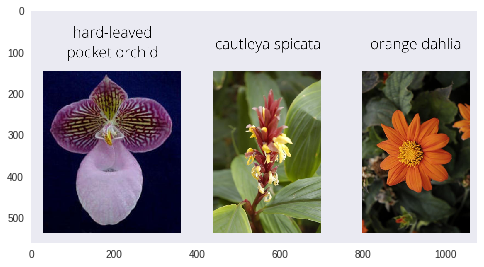

In [0]:
### Flower examples
flowers = mpimg.imread("/content/drive/My Drive/PyTorch Challenge/flowers.png")
plt.imshow(flowers)
plt.grid(False) 

In [0]:
### Install Pillow 
!pip install -q pillow==4.1.1

In [0]:
### Install Pytorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
### Import packages
import json
import torch
import PIL
import copy
import time
import numpy as np
import seaborn as sns
from collections import OrderedDict
from torch import nn, optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms, models
from google.colab import files
from PIL import Image

In [0]:
### Install PyDrive
!pip install -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
### Google drive authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Load the data.**

**Here I will use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, I want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If I use a pre-trained network, I will also need to make sure the input data is resized to 224x224 pixels as required by the networks.**

**The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.**

**The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.**

In [0]:
### Load the data
data_dir = "/content/drive/My Drive/PyTorch Challenge/flower_data"
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [0]:
### Define the transforms for the training and validation sets
training_transforms = transforms.Compose([transforms.RandomRotation(45),                                                                                                             
                                          transforms.RandomHorizontalFlip(),                                               
                                          transforms.RandomCrop(224),
                                          transforms.RandomResizedCrop(224), 
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.485,0.456,0.406),
                                                               (0.229,0.224,0.225))])    
                                                                                                                                         
                                                                                                                         
validation_transforms = transforms.Compose([transforms.Resize(256), 
                                            transforms.CenterCrop(224), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485,0.456,0.406),
                                                                 (0.229,0.224,0.225))])
                                       
                                       
### Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform =training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform =validation_transforms)

### Using the image datasets and the transforms, define the dataloaders
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size =32, shuffle =True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size =32)


**Label mapping.**

**You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.**

In [0]:
### Load label mapping file
cat_to_name = drive.CreateFile({'id' : '1zCjC-qnt9eoL6_U_cwgx-E-y869_rAPd'})
cat_to_name.GetContentFile('cat_to_name.json')
cat_to_name = json.load(open('cat_to_name.json'))
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

**Building and training the classifier.**

**Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.**

**Things you'll need to do:**

* **Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)**

* **Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.**

* **Train the classifier layers using backpropagation using the pre-trained network to get the features.**

* **Track the loss and accuracy on the validation set to determine the best hyperparameters.**

**When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.**

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad_(False)
    
model.classifier = nn.Sequential(OrderedDict([
                                ('fc1', nn.Linear(25088, 4096)),
                                ('relu1', nn.ReLU()),
                                ('fc2', nn.Linear(4096, 102)),                           
                                ('output', nn.LogSoftmax(dim=1)) 
                                ])) 
steps = 0
epochs = 1
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

model.to(device) 

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:09<00:00, 59938987.03it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
### Training loop
for epoch in range(epochs):
    scheduler.step()
    train_loss = 0
  
    model.train()
    train_losses = []
    for inputs, labels in training_dataloader:
        inputs, labels = inputs.to(device), labels.to(device) 
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
           
        loss = criterion(logps, labels)
    
        loss.backward()
                
        optimizer.step() 
 
        train_loss += loss.item()
           
    ### Validation loop 
    model.eval()
    accuracy = 0
    valid_loss = 0
    valid_losses = []
    for inputs, labels in validation_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
    
        output = model.forward(inputs)
    
        loss = criterion(output, labels)
    
        valid_loss += loss.item()
    
        ps = torch.exp(output)
        top_ps, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
       
    print("Epoch {}/{}.. ".format(epoch+1, epochs),
          "Training loss: {:.3f}.. ".format(train_loss / len(training_dataloader)),  
          "Validation loss: {:.3f}..".format(valid_loss / len(validation_dataloader)),
          "Validation accuracy: {:.3f}..".format(accuracy / len(validation_dataloader)))
   
    model.train()

Epoch 1/1..  Training loss: 3.113..  Validation loss: 2.594.. Validation accuracy: 0.340..


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
### Save the checkpoint

model.epochs = epochs
model.accuracy = accuracy
model.train_loss = train_loss
model.valid_loss = valid_loss
model.cat_to_name = cat_to_name
model.class_to_idx = training_dataset.class_to_idx

model.scheduler = scheduler
model.optimizer = optimizer
model.criterion = criterion

checkpoint_path = "/content/drive/My Drive/Saved Checkpoint/checkpoint.pt"

model.to(device)
                  
checkpoint = {'state_dict': model.state_dict(),                                         
              'class_to_idx': model.class_to_idx}
              
     
torch.save(checkpoint, checkpoint_path)                

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
### Load the checkpoint and rebuild the model
def load_checkpoint(checkpoint_path):
    
    checkpoint = torch.load(checkpoint_path)  
    
    #model = checkpoint['model']
    #model.epochs = checkpoint['epochs']
    #model.accuracy = checkpoint['accuracy']
    #model.train_loss = checkpoint['train_loss']
    #model.valid_loss = checkpoint['valid_loss']    
    #model.cat_to_name = checkpoint['cat_to_name']  
    model.load_state_dict(checkpoint['state_dict'])
    
    #model.scheduler.load_state_dict(checkpoint['scheduler'])
    #model.optimizer.load_state_dict(checkpoint['optimizer'])                       
    #model.criterion.load_state_dict(checkpoint['criterion'])  
    
    model.class_to_idx = checkpoint['class_to_idx']    
    
    model.eval() 
    
    return model 

In [0]:
### Call 'load checkpoint()'
model = load_checkpoint(checkpoint_path)
print("Model:\n", model, '\n')
print("Model State Dict:\n", model.state_dict().keys(), '\n')  

Model:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(

In [0]:
### Print 'class_to_idx'
print("Class to idx:\n", model.class_to_idx) 

Class to idx:
 {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, 

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
### Image path
image_path = train_dir + '/1/image_06742.jpg'

In [0]:
### Image processing 
def process_image(image_path):
    
    ### Open image
    image = Image.open(image_path)
    
    image_transforms = transforms.Compose([transforms.Resize(256),
                                           transforms.CenterCrop(224), 
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485,0.456,0.406],
                                                                [0.229,0.224,0.225])])  
    
    image = image_transforms(image)
    image = np.array(image)
        
    print(image.shape, '\n') 
    
    return image

In [0]:
### Call 'process image()'
image = process_image(image_path)  

(3, 224, 224) 



To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
### Display the image
def imshow(image, ax=None, title=None):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ### PyTorch tensors assume the color channel is the first dimension
    ### but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    ### Set the title 
    flower_name = cat_to_name['1']
    plt.title(flower_name)
    
    ### Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    ### Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.grid(False) 
        
    return ax

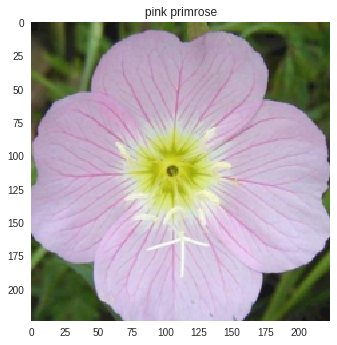

In [0]:
### Call 'imshow()' 
imshow(image, ax=None, title=None)  

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
### Define prediction function 
def predict(image_path, model, topk=5):
         
    model.eval()
    model.to(device) 
    
    with torch.no_grad():      
     
      image = process_image(image_path)  
      image = torch.from_numpy(image).type(torch.FloatTensor)
           
      image = image.unsqueeze(0)
      image = image.to(device)
     
      output = model(image)
      preds = torch.exp(output)
        
      probs, indices = torch.topk(preds, topk, dim =1)   
      print("Indices:\n", indices, '\n')
      
      idx_to_class = {key:val for val, key in model.class_to_idx.items()}
      print("Idx_To_Class:\n", idx_to_class, '\n')
      
      classes = [idx_to_class[i] for i in np.array(indices)[0]]
      flowers = [cat_to_name[j] for j in classes]
      
      return probs, classes, flowers

In [0]:
probs, classes, flowers = predict(image_path, model, topk=5) 

print("Probs:\n", probs, '\n') 
print("Classes:\n", classes, '\n')
print("Flowers:\n", flowers)

(3, 224, 224) 

Indices:
 tensor([[49, 84, 51, 50, 64]], device='cuda:0') 

Idx_To_Class:
 {0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: 

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
### Display the image along with the top 5 classes
def display_prediction(image, image_path, model, topk=5):
    
    plt.figure(figsize =  (6, 10))
    ax = plt.subplot(2, 1, 1)
    ax = imshow(image, ax)
    
    probs, classes, flowers = predict(image_path, model, topk=5)
    probs = np.array(probs)[0]
    
    print("Probs:\n", probs, '\n')
    print("Flowers:\n", flowers, '\n')
    
    plt.subplot(2,1,2)
    
    ax = sns.barplot(x=probs, y=flowers)   
        
    plt.grid(False) 
    plt.show()

(3, 224, 224) 

Indices:
 tensor([[49, 84, 51, 50, 64]], device='cuda:0') 

Idx_To_Class:
 {0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: '84', 86: '85', 87: '86', 88: '87', 89: '88', 90: '89', 91: '9', 92: 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


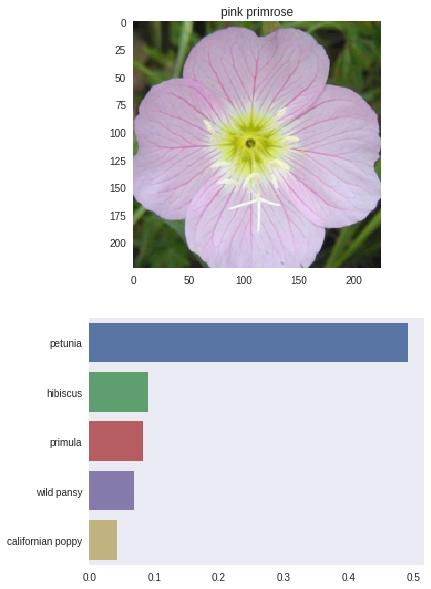

In [0]:
display_prediction(image, image_path, model, topk=5)